In [ ]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report,accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = "/content/drive/MyDrive/dataset botol 2"

In [ ]:
train_dir = "/content/drive/MyDrive/dataset_split3/train"
test_dir = "/content/drive/MyDrive/dataset_split3/test"
val_dir = "/content/drive/MyDrive/dataset_split3/val"

In [ ]:
# Data augmentation dan normalisasi untuk training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

# Generator untuk data pelatihan
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128, 128),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical")

# Generator untuk data validasi
valid_generator = train_datagen.flow_from_directory(val_dir,
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    class_mode="categorical")

# Data augmentation untuk test set, hanya melakukan normalisasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data pengujian
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128, 128),
                                                  color_mode="rgb",
                                                  batch_size=32,
                                                  class_mode="categorical")


Found 824 images belonging to 3 classes.
Found 206 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weight Dictionary:")
print(class_weight_dict)

Class Weight Dictionary:
{0: 0.9809523809523809, 1: 1.0098039215686274, 2: 1.0098039215686274}


In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
# Memulai dengan output dari base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,427,459 (9.26 MB)

 Trainable params: 166,915 (652.01 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Gunakan categorical_crossentropy untuk target one-hot
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6868 - loss: 0.8734 - val_accuracy: 0.8447 - val_loss: 0.4440 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8192 - loss: 0.4720 - val_accuracy: 0.8301 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8726 - loss: 0.3512 - val_accuracy: 0.8495 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8752 - loss: 0.3457 - val_accuracy: 0.8689 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9114 - loss: 0.2494 - val_accuracy: 0.8738 - val_loss: 0.3061 - learning_rate: 0.0010
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9180 - loss: 0.2059 - val_accuracy: 0.8689 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9286 - loss: 0.1989 - val_accuracy: 0.8981 - va

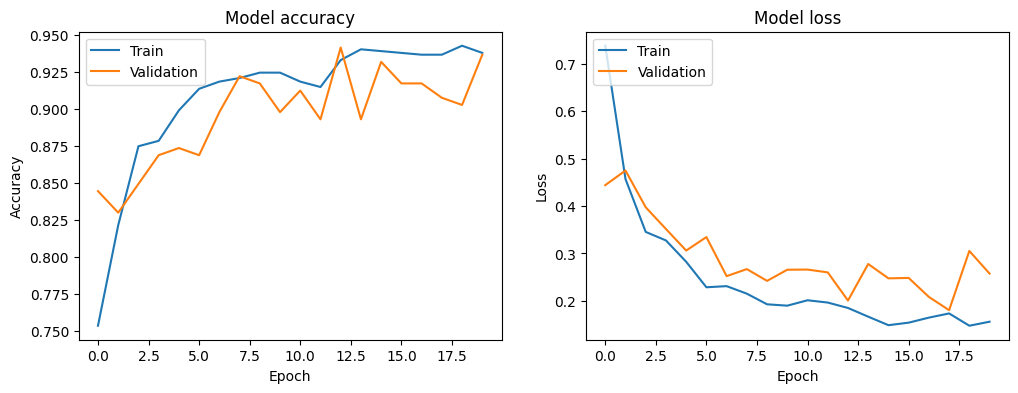

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8834 - loss: 0.3574
Test Loss: 0.4019491672515869
Test Accuracy: 0.8828125


In [ ]:
model.save( "/content/drive/MyDrive/dataset_split3/mymodel2.h5")

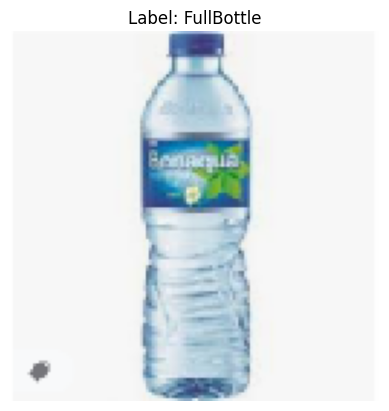

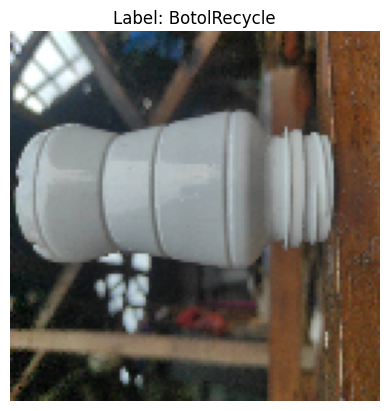

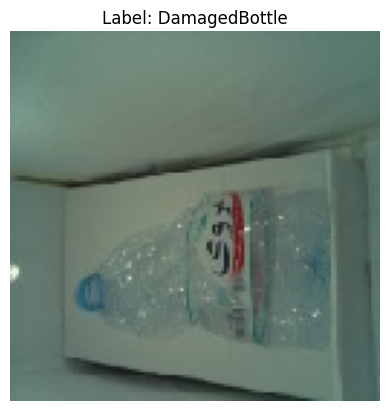

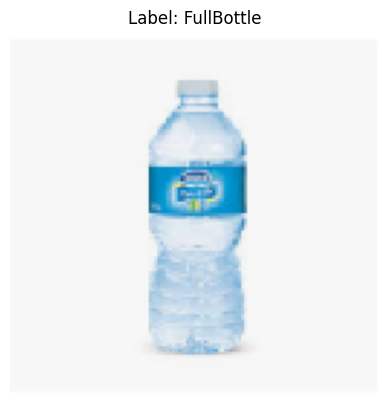

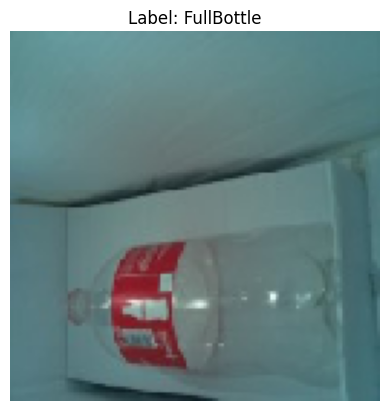

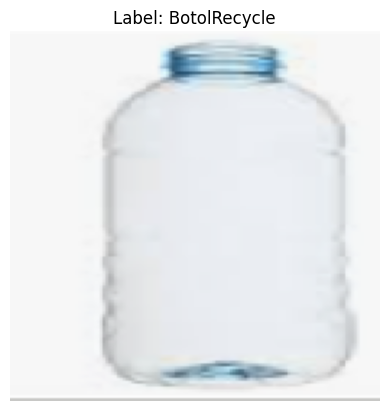

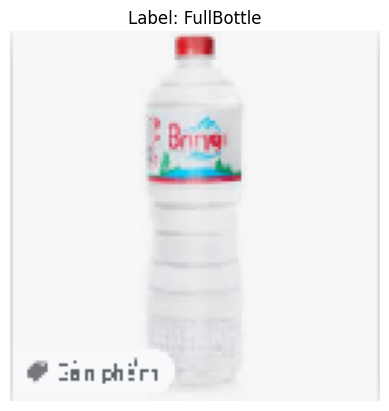

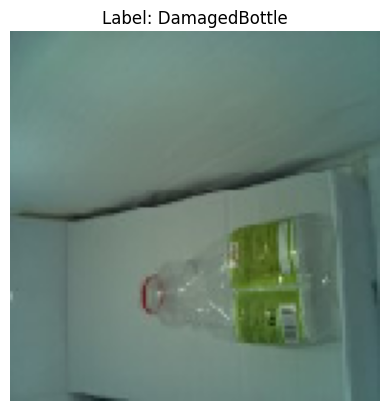

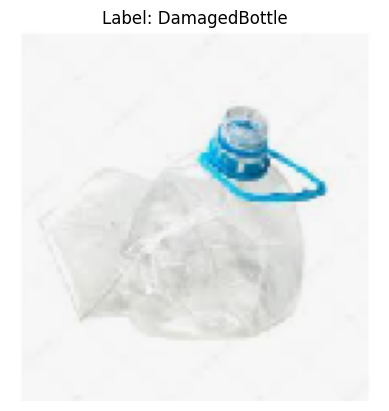

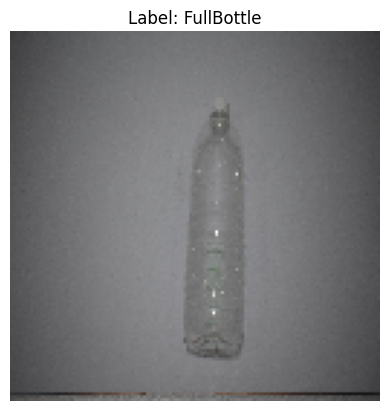

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(128, 128))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(10):
    load_and_display_random_image_with_label()


In [ ]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

In [ ]:
def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:

def predict_image(model, img_path, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100  # Convert to percentage
    return class_labels[predicted_class], confidence

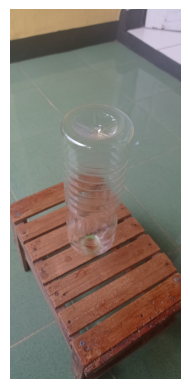

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: BotolRecycle, Confidence: 99.40%


In [ ]:
img_path = '/content/bottle_img (17).jpg'

# Define the class labels based on your dataset
class_labels = ['BotolRecycle','DamagedBottle', 'FullBottle']

# Display the image
display_image(img_path)

# Predict the image
predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
